# Sensing and motion - updating a proba distribution

In this notebook, let's go over the steps a robot takes to help localize itself from an initial, uniform distribution to sensing, moving and updating that distribution.

In [1]:
# importing resources
import matplotlib.pyplot as plt
import numpy as np

A helper function for visualizing a distribution.

### Helpers

In [2]:
def display_map(grid, bar_width=1):
    if(len(grid) > 0):
        x_labels = range(len(grid))
        plt.bar(x_labels, height=grid, width=bar_width, color='b')
        plt.xlabel('Grid Cell')
        plt.ylabel('Probability')
        plt.ylim(0, 1) # range of 0-1 for probability values 
        plt.title('Probability of the robot being at each cell in the grid')
        plt.xticks(np.arange(min(x_labels), max(x_labels)+1, 1))
        plt.show()
    else:
        print('Grid is empty')


# Sensing

[0.04000000000000001, 0.12, 0.12, 0.04000000000000001, 0.04000000000000001]


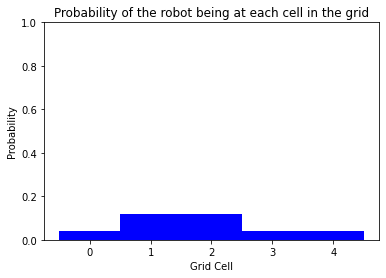

In [26]:
# given initial variables
p=[0.2, 0.2, 0.2, 0.2, 0.2]
# the color of each grid cell in the 1D world
world=['green', 'red', 'red', 'green', 'green']
# Z, the sensor reading ('red' or 'green')
Z = 'red'
pHit = 0.6
pMiss = 0.2

def sense(p, Z):
    ''' Takes in a current probability distribution, p, and a sensor reading, Z.
        Returns an unnormalized distribution after the sensor measurement has been made, q.
        This should be accurate whether Z is 'red' or 'green'. '''
    
    q = []
    for p, w in zip(p, world):
        hit = (Z == w)
        q.append(p * (hit * pHit + (1-hit) * pMiss))
    return q

q = sense(p,Z)
print(q)
display_map(q)

### Sensing + Normalization

In [27]:
def sense_normalized(p, Z):
    ''' Takes in a current probability distribution, p, and a sensor reading, Z.
        Returns an unnormalized distribution after the sensor measurement has been made, q.
        This should be accurate whether Z is 'red' or 'green'. '''
    
    q = []
    for p, w in zip(p, world):
        hit = (Z == w)
        q.append(p * (hit * pHit + (1-hit) * pMiss))
    s = sum(q)
    q = [i/s for i in q]
    return q

Z = 'red'
q = sense_normalized(p,Z)
print(q)

[0.1111111111111111, 0.3333333333333332, 0.3333333333333332, 0.1111111111111111, 0.1111111111111111]


### Test with Green

In [28]:
# Z, the sensor reading ('red' or 'green')
Z = 'green'

q = sense_normalized(p,Z)
print(q)

[0.2727272727272727, 0.09090909090909093, 0.09090909090909093, 0.2727272727272727, 0.2727272727272727]


### With multiple measurements

In [31]:
Z = ['red', 'green']

for z in Z:
    p = sense_normalized(p,z)

print(p)

[0.2, 0.19999999999999993, 0.19999999999999993, 0.2, 0.2]


# Moving

### Shifts - exact motion

In [36]:
def move(p, U):
    """U=1 shifts of 1 to the right,
       U=3 shifts of 3 to the right,
       U=-1 shifts of 1 to the left"""
    q = []
    for i in range(len(p)):
        q.append(p[(i-U) % len(p)])
    return q

In [37]:
p = [0,1,0,0,0]
move(p,2)

[0, 0, 0, 1, 0]

In [42]:
# my version
def move(p,U):
    q = [0]*len(p)
    q[U:], q[:U] = p[0:-U], p[-U:]
    return q

### Shift - inaccurate motion

In [44]:
def inaccurate_move(p, U):
    q = []
    for i in range(len(p)):
        # accumulate different possibility
        s = pExact * p[(i-U) % len(p)]
        s += pUndershoot * p[(i-U-1) % len(p)]
        s += pOvershoot * p[(i-U+1) % len(p)]
        q.append(s)
    return q

In [47]:
pExact = 0.8
pUndershoot = 0.1
pOvershoot = 0.1

p = [0, 1, 0, 0, 0]
inaccurate_move(p,2)

[0.0, 0.0, 0.1, 0.8, 0.1]

### Limit distribution of inifinite inaccurate motion

In [49]:
# infinite motion (1000 steps)
p = [0, 1, 0, 0, 0]

for i in range(1000):
    p = inaccurate_move(p,1)

print(p)

[0.20000000000000365, 0.20000000000000373, 0.20000000000000365, 0.2000000000000035, 0.2000000000000035]


# Combining motion and sensing

In [55]:
# Inaccurate move
def move(p, U):
    q=[]
    # iterate through all values in p
    for i in range(len(p)):
        index = (i-U) % len(p)
        nextIndex = (index+1) % len(p)
        prevIndex = (index-1) % len(p)
        s = pExact * p[index]
        s = s + pOvershoot  * p[nextIndex]
        s = s + pUndershoot * p[prevIndex]
        q.append(s)
        
    # sum up all the components
    s = sum(q)
    # divide all elements of q by the sum to normalize
    for i in range(len(p)):
        q[i] = q[i] / s
    return q

# Inaccurate sense
def sense(p, Z):
    ''' Takes in a current probability distribution, p, and a sensor reading, Z.
        Returns a *normalized* distribution after the sensor measurement has been made, q.
        This should be accurate whether Z is 'red' or 'green'. '''
    q=[]
    # loop through all grid cells
    for i in range(len(p)):
        # check if the sensor reading is equal to the color of the grid cell
        # if so, hit = 1
        # if not, hit = 0
        hit = (Z == world[i])
        q.append(p[i] * (hit * pHit + (1-hit) * pMiss))
        
    # sum up all the components
    s = sum(q)
    # divide all elements of q by the sum to normalize
    for i in range(len(p)):
        q[i] = q[i] / s
    return q

In [56]:
# given initial variables
p=[0.2, 0.2, 0.2, 0.2, 0.2]
# the color of each grid cell in the 1D world
world=['green', 'red', 'red', 'green', 'green']
# Z, the sensor reading ('red' or 'green')
measurements = ['red', 'green']
pHit = 0.6
pMiss = 0.2

motions = [1,1]
pExact = 0.8
pOvershoot = 0.1
pUndershoot = 0.1

In [57]:
for motion, measurement in zip(motions, measurements):
    p = sense(p, measurement)
    p = move(p, motion)
    
print(p)

[0.21157894736842103, 0.15157894736842106, 0.08105263157894736, 0.16842105263157894, 0.38736842105263153]
